In [1]:
from orthofinder_utils import dash_app_preprocess as dap
from orthofinder_utils import proteomes_for_orthofinder as pfo
from orthofinder_utils import dash_ortho_parser_d as dop
from jw_utils import parse_gff as pgf
import os
import pandas as pd
import json
from Bio import Phylo
import shutil
import plotly.graph_objects as go
from jw_utils import ncbi_datasets_fxs as nfx
from jw_utils import jw_ncbi_taxonomy as jnt
from ete3 import ncbi_taxonomy
from jw_utils import plotly_preferences as pprefs
ncbi_tax = ncbi_taxonomy.NCBITaxa()
import plotly.io as pio

ncbi.datasets module not found. To install, run `pip install ncbi-datasets-pylib`.


### Work with HOG that is the last common ancestor of all baumannii.

In [2]:
dop_obj = dop.DashOrthoParser('./data', tax_level='N4')

In [3]:
HOGs_in_ast2 = {'AAtransporter_HOG' : 'N4.HOG0003342',
                        'astA2_HOG' : 'N4.HOG0003338',
                        'astC2_HOG' : 'N4.HOG0000110',
                         'asnC_HOG' : 'N4.HOG0003154', }

path_N4_HOGcounts = './data/Proteomes/OrthoFinder/Results_May12_2/Phylogenetic_Hierarchical_Orthogroups/N4.tsv'
df = pd.read_csv(path_N4_HOGcounts, sep='\t').set_index('HOG').drop(['OG', 'Gene Tree Parent Clade'], axis=1).transpose()

/var/folders/f4/b2mhwx4x4lqgtss5t8r9cxqh0000gn/T/ipykernel_16136/3689988249.py:7: DtypeWarning: Columns (10,178) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_N4_HOGcounts, sep='\t').set_index('HOG').drop(['OG', 'Gene Tree Parent Clade'], axis=1).transpose()


### Make itol annotation files

In [4]:
AAtransporter_simplebar = './itol/itol_simplebar_AAtransportercounts.txt'
astA2_simplebar = './itol/itol_simplebar_AstA2counts.txt'
astC2_simplebar = './itol/itol_simplebar_AstC2counts.txt'
asnC_simplebar = './itol/itol_simplebar_asnCcounts.txt'


def add_counts_itol_simplebar(path_to_simplebar, df_HOG_counts, HOG):
    """Append df.index[i] and counts of protq, prot2 that exist in a cell
    
    parameters:
    path_to_simplebar (str): path to simple bar itol annotation file. node IDs and counts will be appended to end of file
    df_HOG_counts (pd.DataFrame): df with node ID as index, and column with proteins in format of WP_####, WP_####, AK_###, will be counted as 3 proteins
    """
    
    with open(path_to_simplebar, 'a') as f:
        for acc in df.index:
            prots = df.loc[acc, HOG]
            if isinstance(prots,float):
                counts = 0
            else:
                counts = len(prots.split(', '))
                prots = prots.split(', ')
            f.write(f'{acc},{counts}\n')
            
add_counts_itol_simplebar(AAtransporter_simplebar, df, HOGs_in_ast2['AAtransporter_HOG'])
add_counts_itol_simplebar(astA2_simplebar, df, HOGs_in_ast2['astA2_HOG'])            
add_counts_itol_simplebar(astC2_simplebar, df, HOGs_in_ast2['astC2_HOG'])
add_counts_itol_simplebar(asnC_simplebar, df, HOGs_in_ast2['asnC_HOG'])            


In [5]:
path_to_itol_labels = './itol/itol_labels.txt'
with open(path_to_itol_labels, 'a') as f:
    for acc, name in dop_obj.accession_to_name.items():
        name = name.replace('Acinetobacter', 'A.')
        name = name.replace('baumannii', 'baum.')
        f.write(f'{acc},{name}\n')


### Get counts for HOGs in each genome

In [6]:

def get_HOG_counts(HOG, HOG_prots_df, ignore_d):
    """"""
    counts = {}
    missing = 0
    for acc in HOG_prots_df.index:
        if acc not in ignore_d.values():
            prots = df.loc[acc, HOG]
            if isinstance(prots,float):
                counts[acc] = 0
                missing +=1
            else:
                count = len(prots.split(', '))
                counts[acc] = count
    return counts, missing



non_baumannii_d = {'Acinetobacter baylyi ADP1': 'GCF_000046845.1',
 'Acinetobacter colistiniresistens NIPH 2036': 'GCF_000413935.1',
 'Acinetobacter gyllenbergii FMP01': 'GCF_001682515.1',
 'Acinetobacter nosocomialis M2': 'GCF_005281455.1'}



In [7]:
def fraction_with_HOG(HOG, HOG_prots_df, ignore_d):
    counts, missing = get_HOG_counts(HOG, df, ignore_d)
    return (1 - (missing/len(counts)))


fractions = {}
for name, HOG in HOGs_in_ast2.items():

    fractions[name] = fraction_with_HOG(HOG, df, non_baumannii_d)


In [75]:
counts, missing = get_HOG_counts(HOG, df, non_baumannii_d)

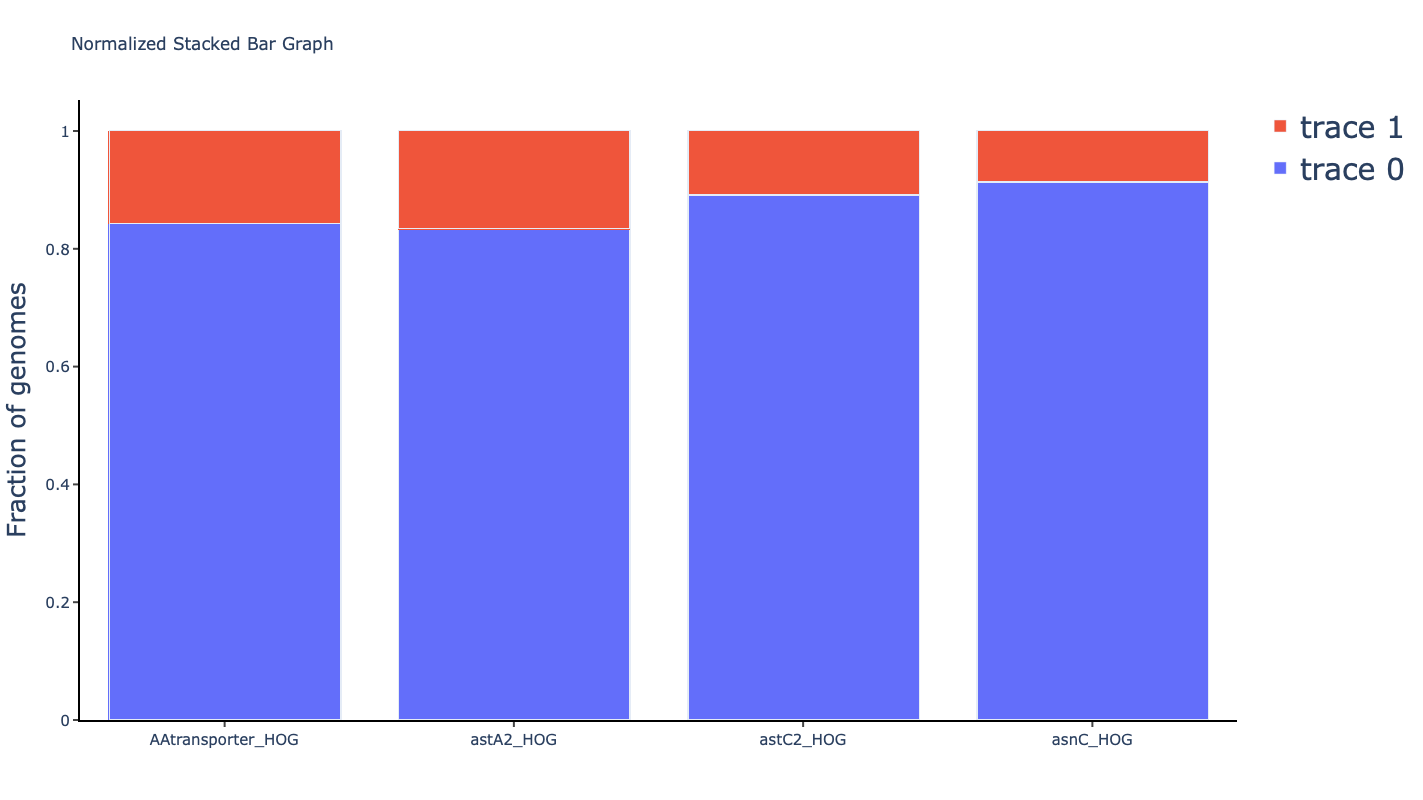

In [46]:

fractions.values()
remaining = [1-val for val in fractions.values()]
layout = pprefs.bargraph_layout(title='Fraction of genomes with protein',x_title = '', y_title="Fraction of genomes")
colors = pprefs.colors

fract_trace = go.Bar(x = list(fractions.keys()), y = list(fractions.values()))
rem_trace = go.Bar(x = list(fractions.keys()), y = remaining)

fig = go.Figure(data=[fract_trace, rem_trace], layout = layout)
fig.update_layout(
    barmode='stack',
    title='Normalized Stacked Bar Graph')


fig

In [47]:
pio.write_image(fig, './figure/initial_fractions_ast2.svg', format='svg')

In [96]:
def find_common_elements(*sets):
    if not sets:  # Handle the case when no sets are provided
        return set()
    new_sets = []
    for s in sets:
        if not isinstance(s, set):
            s = set(s)
        new_sets.append(s)
    return new_sets[0].intersection(*new_sets[1:])


def get_genomes_ast2_coherent(HOGs_in_ast2, df,coherence_type = 'present'):
    """"""
    accs = {}
    for name, HOG in HOGs_in_ast2.items():
        counts, missing = get_HOG_counts(HOG, df, non_baumannii_d)
        dft = pd.DataFrame.from_dict(counts, orient='index')
        if coherence_type == 'present':
            dft = dft.loc[dft[0]>0,:]
        if coherence_type == 'absent':
            dft = dft.loc[dft[0]<1,:]
        accs[name] = list(dft.index)
        
    
    return find_common_elements(*accs.values())
     
    


coherent_present_accs_d = get_genomes_ast2_coherent(HOGs_in_ast2, df, coherence_type = 'present')
coherent_absent_accs_d = get_genomes_ast2_coherent(HOGs_in_ast2, df, coherence_type = 'absent')
d = {}
d['All present'] = len(coherent_present_accs_d)/len(counts)
d['All absent'] = len(coherent_absent_accs_d)/len(counts)
d['Mixed'] = 1-((len(coherent_present_accs_d) + len(coherent_absent_accs_d))/len(counts))

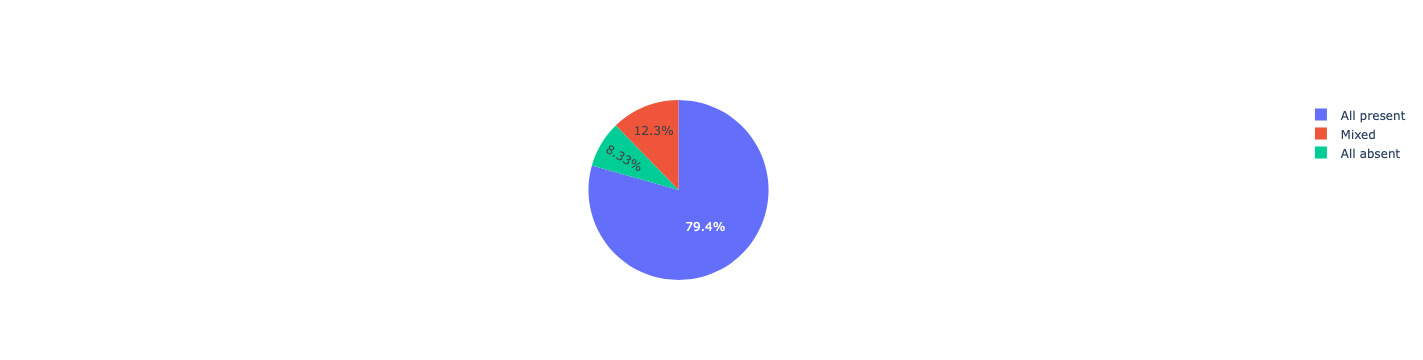

In [97]:
coherence_fig = go.Figure(data=[go.Pie(labels=list(d.keys()), values=list(d.values()))])

# Set title and customize layout if desired
coherence_fig.update_layout(title='')
coherence_fig.update_layout(barmode='stack')

pio.write_image(coherence_fig, './figure/operon_coherence.svg', format='svg')
coherence_fig

### Add manually adjusted ast2 loci. Remove genomes whose contigs begin/end in ast2 loci

In [80]:
remove =  ['1399', '1782', 'L021', '1846']
add_to_all_present = ['D46','OC073', 'NIPH 190', 'B8300', 'Ac18', 'r307', '8530']

def find_accessions_via_keyword(mod_list, dop_obj):
    accs_to_add = []
    for acc in dop_obj.accessions:
        name = dop_obj.accession_to_name[acc]
        for k in mod_list:
            if name.find(k) != -1:
                print(name, acc)
                accs_to_add.append(acc)

    return accs_to_add


accs_to_add = find_accessions_via_keyword(add_to_all_present, dop_obj)

Acinetobacter baumannii B8300 GCF_001077965.2
Acinetobacter baumannii CriePir307 GCF_016654265.1
Acinetobacter baumannii D46 GCF_018831125.1
Acinetobacter baumannii OCU Ac18 GCF_019703285.1
Acinetobacter baumannii OC073 GCF_024749425.1
Acinetobacter baumannii 1598530 GCF_000682415.1
Acinetobacter baumannii NIPH 190 GCF_000368525.1


In [81]:
all_present_accs = list(coherent_present_accs_d) + accs_to_add

In [92]:

mod_all_present = len(all_present_accs)/(len(counts)-4)
mod_coherent_absent = len(coherent_absent_accs_d)/(len(counts)-4)
mod_mixed = 1 - (mod_all_present+mod_coherent_absent_accs)
categories = {'All present':mod_all_present, 'All absent':mod_coherent_absent, 'Mixed': mod_mixed}

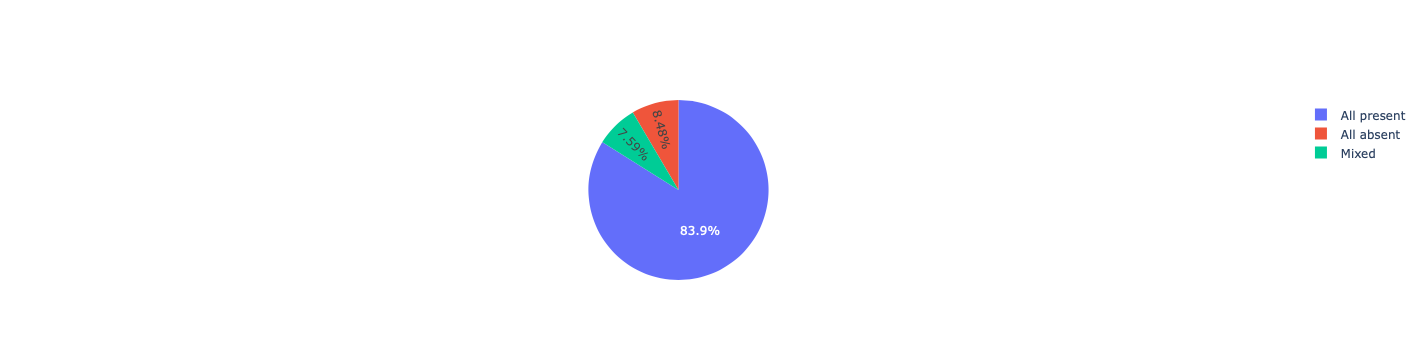

In [99]:
coherence_mod_fig = go.Figure(data=[go.Pie(labels=list(categories.keys()), values=list(categories.values()))])


pio.write_image(coherence_mod_fig, './figure/operon_coherence_modified.svg', format='svg')
coherence_mod_fig